# Consumption of Animal Products in Mainland China
# 中国大陆动物产品的消费情况

## Ready to work  准备

### Import Libraries 导入工具库

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms
import seaborn as sns

import folium
import json
import time
from folium import plugins

import datetime

%matplotlib inline

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('max_colwidth',1000)

### Read Data Frame 读取数据

To visualize data to see where people like to eat what kind of animals in different areas of mainland China, we got:
- Dataset _'food consumption per capita of residents in urban regions (2017)'_ and _'food consumption per capita of residents in rural regions (2017)'_ from [China Statistics Bureau](http://www.stats.gov.cn/tjsj/ndsj/2018/indexch.htm), which shows per capita consumption of the main animal products, such as pork, beef, birds meat, aquatic product, egg and milk in different provinces of China. These two table was collected in [this data frame](./data/NBS/FoodConsumption_areas.csv)
- Dataset _'population structure, Birth rate, mortality rate and natural growth rate in urban and rural regions (2017)'_ from China Statistics Bureau, too. This table was collected in [this data frame](./data/NBS/Population_2017.csv)

In [2]:
data = pd.read_csv('./data/NBS/FoodConsumption_areas.csv')
population = pd.read_csv('./data/NBS/Population_2017.csv') 
geoname = pd.read_csv('./data/NBS/GeoNameSheet_cn.csv')

# print(data.shape)

# display(data.tail())
# display(geoname.head())
# display(population.head())

__各地区的人均消费量 - DataFrame 'df_percapita'__

__人口数 - DataFrame 'df_population：__

In [3]:
df_percapita = pd.merge(geoname, data, on='Area', how='outer')
df_percapita = df_percapita[df_percapita['Year']==2017]
df_percapita = df_percapita.sort_values(['AreaNum','Urban or Rural'])
df_percapita.reset_index(inplace=True)
df_percapita = df_percapita.drop(columns=['index'])
display('Unint: kg/capita/year')
display(df_percapita.head(6))

df_population =  pd.merge(geoname, population, on='Area', how='outer')
display('Unit: 10,000 people')
display(df_population.head())

'Unint: kg/capita/year'

,AreaNum,Area,Region,Year,Urban or Rural,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar
0,41,"China, mainland",East Asia,2017,Rural,154.6,144.8,10.1,9.2,90.2,23.6,19.5,0.9,1.0,7.9,7.4,8.9,6.9,38.4,1.4
1,41,"China, mainland",East Asia,2017,Urban,109.7,98.6,10.7,10.3,106.7,29.2,20.6,2.6,1.6,9.7,14.8,10.9,16.5,59.9,1.3
2,1001,Beijing,North China,2017,Rural,96.7,86.9,9.0,9.0,88.7,22.2,14.4,1.7,3.0,4.0,5.6,11.8,12.9,51.7,1.2
3,1001,Beijing,North China,2017,Urban,72.4,64.0,8.2,8.2,92.4,23.1,12.4,3.1,2.8,5.7,9.0,12.1,24.0,65.8,1.0
4,1002,Tianjin,North China,2017,Rural,153.9,142.9,12.8,12.7,99.0,22.0,14.4,0.9,2.3,4.1,12.6,16.7,12.0,81.8,1.7
5,1002,Tianjin,North China,2017,Urban,112.9,102.6,10.5,10.4,120.0,27.5,16.2,3.5,3.3,6.0,17.8,18.6,18.4,86.1,1.4


'Unit: 10,000 people'

,AreaNum,Area,Region,Year,Total Population - Both sexes,Urban population,Rural population
0,41,"China, mainland",East Asia,2017,139008,81347,57661
1,1001,Beijing,North China,2017,2171,1878,293
2,1002,Tianjin,North China,2017,1557,1291,266
3,1003,Hebei,North China,2017,7520,4136,3383
4,1004,Shanxi,North China,2017,3702,2123,1579


### Data preprocessing 数据预处理

1. 除上述已给出的各地区城镇人均消费量，各地区农村人均消费量，以及各地区城镇和农村的人口数量，计算下列数据：
    - ```各地区城镇消费总量 = 各地城镇人均消费量 × 各地城镇人口（单位：万吨）```
    - ```各地区农村消费总量 = 各地农村人均消费量 × 各地农村人口（单位：万吨）```
    - ```各地区消费总量 = 各地城镇消费总量 + 各地农村消费总量（单位：万吨）```

    
- 所得 DataFrame 保存为变量`df_total` 。

In [4]:
areas = geoname.Area.unique()

# 创建表格
df_total = pd.DataFrame()
cols_meta = df_percapita.columns[:5]
cols_items = df_percapita.columns[5:]
for col in cols_meta:
    df_total[col]=df_percapita[col]    
    
# 计算各地区城镇消费总量
for col in cols_items:
    for area in areas:
        df_total.loc[(df_total['Urban or Rural']=='Rural') & (df_total['Area']==area),col]\
        =df_percapita.loc[(df_percapita['Urban or Rural']=='Rural') & (df_percapita['Area']==area),col].values[0]\
        *df_population.loc[df_population['Area']==area,'Rural population'].values[0]/1000

# 计算各地区农村消费总量
for col in cols_items:
    for area in areas:
        df_total.loc[(df_total['Urban or Rural']=='Urban') & (df_total['Area']==area),col]\
        =df_percapita.loc[(df_percapita['Urban or Rural']=='Urban') & (df_percapita['Area']==area),col].values[0]\
        *df_population.loc[df_population['Area']==area,'Urban population'].values[0]/1000
# display('Unit: 10,000 t')
# df_total.tail()

# 创建表格
df_national_total = pd.DataFrame()
cols_meta = df_total.columns[:4]
cols_items = df_total.columns[5:]
for col in cols_meta:
    df_national_total[col]=df_population[col]
df_national_total['Urban or Rural']='Urban & Rural'
areas = geoname.Area.unique()

# 补充各地区消费总量
for col in cols_items:
    for area in areas:
        df_national_total.loc[df_national_total['Area']==area,col]\
        =df_total.loc[(df_total['Urban or Rural']=='Rural') & (df_total['Area']==area),col].values[0]\
        +df_total.loc[(df_total['Urban or Rural']=='Urban') & (df_total['Area']==area),col].values[0]

# 合并表格后，df_total 的每个 item 含以下数据：
#    各地区城镇消费总量 
#    各地区农村消费总量
#    各地区消费总量
df_total = pd.concat([df_total, df_national_total], sort = False)
df_total = df_total.sort_values(['AreaNum','Urban or Rural'])
df_total.reset_index(inplace=True)
df_total = df_total.drop(columns=['index'])
display('Unit: 10,000 t')
display(df_total.tail(6))

'Unit: 10,000 t'

,AreaNum,Area,Region,Year,Urban or Rural,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar
90,1030,Ningxia,Northwest China,2017,Rural,36.7647,34.7844,2.2099,2.2099,22.0703,4.0467,1.7220,0.9471,1.2054,1.6933,0.3731,1.1767,2.1525,18.3393,0.3444
91,1030,Ningxia,Northwest China,2017,Urban,37.8805,35.2340,3.0020,3.0020,38.1570,6.7545,2.6070,1.5405,2.0145,2.4095,1.5010,2.6860,7.3865,30.7705,0.5530
92,1030,Ningxia,Northwest China,2017,Urban & Rural,74.6452,70.0184,5.2119,5.2119,60.2273,10.8012,4.3290,2.4876,3.2199,4.1028,1.8741,3.8627,9.5390,49.1098,0.8974
93,1031,Xinjiang,Northwest China,2017,Rural,224.2018,222.5924,17.7034,17.5796,102.2588,23.8934,2.2284,4.7044,16.2178,5.5710,1.2380,5.5710,16.3416,61.5286,1.2380
94,1031,Xinjiang,Northwest China,2017,Urban,159.9275,152.3234,16.8980,16.8980,141.3397,29.3301,7.8455,6.6385,12.0700,9.2939,7.3627,10.8630,36.6928,86.6626,1.8105
95,1031,Xinjiang,Northwest China,2017,Urban & Rural,384.1293,374.9158,34.6014,34.4776,243.5985,53.2235,10.0739,11.3429,28.2878,14.8649,8.6007,16.4340,53.0344,148.1912,3.0485


2. 将各地区的消费总量经归一化处理（与全国消费总量相比）后，再用其评价各地区对某动物类食品的总消费能力：

    __```各地区消费总量占全国消费总量的百分比 = 各地区消费总量 / sum(各地区消费总量) （单位：%）```__

- 将归一化处理后的 DataFrame 保存到变量 __`total_norm`__

In [5]:
# 计算全国总量
cn_total = df_total[(df_total['Area']=='China, mainland') & (df_total['Urban or Rural']=='Urban & Rural')]

# 创建表格
areas_total = df_total[(~df_total['Area'].isin(['China, mainland'])) & (df_total['Urban or Rural']=='Urban & Rural')]
total_norm = pd.DataFrame()
for col in cols_meta:
    total_norm[col] = areas_total[col]

# 计算各地区消费总量占全国消费总量的百分比（归一化处理）
for col in cols_items:
    total_norm[col] = areas_total[col]/cn_total[col].values[0]*100

display(total_norm.head())

,AreaNum,Area,Region,Year,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar
5,1001,Beijing,North China,2017,0.921061,0.889753,1.241515,1.318123,1.437360,1.335242,0.982323,2.399381,3.267769,0.954260,1.137158,1.870266,2.807430,1.957430,1.195647
8,1002,Tianjin,North China,2017,1.046584,1.041336,1.167430,1.228087,1.305794,1.106880,0.883692,1.806360,2.594079,0.710002,1.614802,2.032681,1.548567,1.875496,1.211734
11,1003,Hebei,North China,2017,5.208776,5.227360,4.802907,5.049821,4.821914,3.985879,3.340475,4.410793,5.805197,2.564640,2.771419,7.603061,6.557588,6.578733,4.394977
14,1004,Shanxi,North China,2017,2.771315,2.681750,2.060664,2.176277,2.094896,1.402622,1.258485,1.167705,2.678257,0.710356,0.558865,2.894586,3.299037,2.743848,2.040740
17,1005,Neimenggu,North China,2017,2.147034,2.146803,1.466097,1.505552,1.610606,2.294298,1.526896,4.176660,12.108008,1.083057,0.772991,1.659188,3.365454,2.041304,2.015321


3. 将各地区的人均消费各动物产品量归一化处理（与占其主要食品消费总量相比）后，再用其评价某地区城镇（或农村）对某动物类食品的人均消费能力：

    ```各地区城镇（或农村）人均消费某动物产品占其主要食品消费量的百分比 = 各地区城镇（或农村）人均消费某动物产品量 / 各地区城镇（或农村）人均主要食品消费量```
    
- 将归一化处理后的 DataFrame 保存到变量 `percapita_norm`

In [6]:
df = df_percapita.copy()
# display(df.head())

# 分类：

# 非动物性食品
df['Non-animal Products']=df['Main Grain']+df['Edible Oil, vegetable']+df['Vegetable & Fungus']+df['Melon & Fruit']+df['Sugar']
# 肉类
df['Meat']=df['Pigmeat']+ df['Bovine Meat']+df['Mutton & Goat Meat']+df['Poultry Meat']
# 水产：'Fish, Seafood'，不需要处理
# 鸡蛋：'Eggs'，不需要处理
# 牛奶：'Milk'不需要处理

# 合计:
df['Sum'] = df['Non-animal Products']+df['Meat']+df['Fish, Seafood']+df['Milk']

percapita_norm=df.copy()
# 归一化处理：
for col in df.columns[5:]:
    percapita_norm[col] = df[col]/df['Sum'] * 100
display(percapita_norm.head())

,AreaNum,Area,Region,Year,Urban or Rural,Main Grain,"Main Grain, cereal",Edible Oil,"Edible Oil, vegetable",Vegetable & Fungus,Meat of Mammal,Pigmeat,Bovine Meat,Mutton & Goat Meat,Poultry Meat,"Fish, Seafood",Eggs,Milk,Melon & Fruit,Sugar,Non-animal Products,Meat,Sum
0,41,"China, mainland",East Asia,2017,Rural,45.820984,42.916420,2.993480,2.726734,26.733847,6.994665,5.779490,0.266746,0.296384,2.341434,2.193242,2.637819,2.045050,11.381150,0.414938,87.077653,8.684055,100.0
1,41,"China, mainland",East Asia,2017,Urban,31.014984,27.876732,3.025163,2.912072,30.166808,8.255584,5.824145,0.735086,0.452361,2.742437,4.184337,3.081708,4.664970,16.935256,0.367543,81.396664,9.754029,100.0
2,1001,Beijing,North China,2017,Rural,33.471790,30.079612,3.115265,3.115265,30.702665,7.684320,4.984424,0.588439,1.038422,1.384562,1.938387,4.084458,4.465213,17.895466,0.415369,85.600554,7.995846,100.0
3,1001,Beijing,North China,2017,Urban,24.393531,21.563342,2.762803,2.762803,31.132075,7.783019,4.177898,1.044474,0.943396,1.920485,3.032345,4.076819,8.086253,22.169811,0.336927,80.795148,8.086253,100.0
4,1002,Tianjin,North China,2017,Rural,38.922610,36.140617,3.237228,3.211937,25.037936,5.563986,3.641882,0.227618,0.581689,1.036925,3.186646,4.223571,3.034901,20.687911,0.429944,88.290339,5.488113,100.0


### Plot style settings 设置输出风格

In [7]:
plt.style.use(['ggplot'])

# font size
TIT_size = 18    # titles
LAB_size = 14    # labels
LEG_size = 14    # legends
TCK_size = 14    # ticklabels

LIN_wei = 2.5    # line weights
BAR_wid = 0.8      # bar width
GRD_wid = 0.5    # grid line width
GRD_clr = 'white' 
GRD_aph = 1     # grid alpha

CLs = ('lightgreen', 'limegreen','g','hotpink','maroon','orangered','gold','deepskyblue','yellowgreen','darkgray','chocolate',
       'r','orange','maroon','hotpink','b','yellowgreen','deepskyblue','g','c','lightslategray','k')
MKs = ('o', 'x','o','x', 'v','.','v','.','o','x','o', 'x', 'v','.','v','.')
LSs = ('-','-','--', ':', ':','-.','-.','-','-','--','--', ':', ':','-.','-.')

# =============================================================================================================
def setX_quant(ax, ticks, step, label = ''):
    ax.set_xticks(ticks)
    ax.set_xlim(ticks[0]-step,ticks[-1]+step)
    ax.set_xticklabels(ticks, rotation=0, ha='center', fontsize=TCK_size)
    ax.set_xlabel(label, fontsize=LAB_size)
    ax.xaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)
    
def setX_quali(ax, ticks, label = ''):
    ax.set_xticklabels(ticks, rotation=90, ha='center', fontsize=TCK_size)
    ax.set_xlabel(label, fontsize=LAB_size)
    ax.xaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)

def setY_quant(ax, y_max, label = ''):
    tick_num = 9
    step = y_max/(tick_num-1)
    min_gap = 10
    
    if step < 1:
        step = round(step,1)
        dec=1
    elif step < 10:
        step = int(step)
        dec=0
    elif step/min_gap < 10:
        step = int(step/min_gap)*10
        dec=0
    else:
        n=0
        while step/min_gap >= 10:
            step = int(step/min_gap)
            n += 1
        step = int(step/min_gap)*(min_gap**(n+1))
        dec=0
        
    y_max = step*(tick_num+1)        
    ticks = np.round(np.arange(0, y_max+step, step),decimals=dec)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1]+step)
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel(label, fontsize=LAB_size)    
    ax.yaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)
    
def setY_per(ax):
    ticks=np.round(np.linspace(0, 100, num=11, endpoint=True), decimals=0)
    ax.set_yticks(ticks)
    ax.set_ylim(ticks[0],ticks[-1])
    ax.set_yticklabels(ticks, fontsize=TCK_size)
    ax.set_ylabel('Percentage (%)', fontsize=LAB_size)
    ax.yaxis.grid(True, linewidth=GRD_wid, color=GRD_clr, alpha=GRD_aph)

## Results 结果

### 各地区消费总量占全国消费总量的百分比

- Draw Atlas and Venns by Using __`total_norm`__

#### Atlas

In [8]:
def plotAtlas(
    df_,           # dataframe, the gross dataframe
    items_,        # string, selected item
    year_,         # int, selected year
    geo_data_,     # geojson file
    fill_color_,   # string, select a fill_color strategy in folium
    tag_,          # string, for recognization when giving title and saving files
):

    df_ = df_.copy()
    
    # create a dict of sub dataframes that made of 
    # a particular year, a particular item, ertain areas
    # and sorted by item value
    dfs = {}
    df_sorted = pd.DataFrame([])
    for i in items_:
        dfs[i] = df_[df_['Year']==year_][['Area',i]]
        dfs[i] = dfs[i].sort_values([i],ascending=False).reset_index(drop=True)
        df_sorted = pd.concat([df_sorted, dfs[i]], axis=1, join='outer', ignore_index=False)
    display(df_sorted)
   
    for i in items_:
        title = "{} {} {}".format(str(year_), i, tag_)
        cn_map = folium.Map( width=1000, height=600, location=[40, 105], zoom_start=4, tiles='Mapbox Bright') 
        
        dfs[i] = dfs[i][~dfs[i]['Area'].isin(['China, mainland'])]
        threshold_scale = np.linspace(
            dfs[i][i].values.min(), 
            dfs[i][i].values.max(), 
            6, dtype=int)
        threshold_scale = threshold_scale.tolist()      # change the numpy array to a list
        threshold_scale[-1] = threshold_scale[-1] + 1   # make sure that the last value of the list is greater than the maximum immigration
        
        folium.Choropleth(
            geo_data=geo_data_,
            data=dfs[i],
            name = i,
            columns=['Area', i],
            key_on='feature.properties.NAME',
            threshold_scale=threshold_scale,
            nan_fill_color='gray',
            fill_color=fill_color_,
            fill_opacity=1, 
            line_opacity=0.2,
            legend_name=title,
            show=False,
            highlight=False,
            reset=False
        ).add_to(cn_map)
        
        path = './results/map/CN_FoodConsumption/'+title+'.html'
        cn_map.save(path)
        print('Atala saved as: ' + path)
#         display(cn_map)


__注意：此处输出结果为地图，不能直接在文本中显示地图，请根据结果输出的地址自行查看__

In [9]:
items = ['Pigmeat', 'Bovine Meat','Mutton & Goat Meat','Poultry Meat','Fish, Seafood', 'Eggs', 'Milk']

plotAtlas(
    df_=total_norm,           # dataframe, the gross dataframe
    items_=items,         # string, selected item
    year_=2017,         # int, selected year
    geo_data_=r'cn_provinces.geojson',     # geojson file
    fill_color_='OrRd',   # string, select a fill_color strategy in folium
    tag_="- Area Proportion to National, Percent",
)

,Area,Pigmeat,Area,Bovine Meat,Area,Mutton & Goat Meat,Area,Poultry Meat,Area,"Fish, Seafood",Area,Eggs,Area,Milk
0,Guangdong,11.584909,Guangdong,8.811297,Xinjiang,15.061427,Guangdong,18.456159,Guangdong,15.686935,Shandong,12.343831,Shandong,10.281248
1,Sichuan,10.716298,Jiangsu,5.868364,Neimenggu,12.108008,Guangxi,7.709830,Jiangsu,9.057246,Henan,9.870415,Jiangsu,7.342676
2,Hunan,6.657287,Hunan,5.449566,Shandong,6.311383,Sichuan,7.347075,Zhejiang,8.292933,Hebei,7.603061,Henan,6.712822
3,Jiangsu,5.627298,Sichuan,5.253247,Henan,6.117364,Jiangsu,6.725544,Shandong,7.445946,Jiangsu,6.176602,Hebei,6.557588
4,Guangxi,4.845744,Shandong,4.821997,Hebei,5.805197,Hunan,5.887507,Fujian,6.274231,Guangdong,5.871337,Sichuan,6.091065
5,Shandong,4.730703,Anhui,4.628145,Guangdong,4.455739,Anhui,5.129787,Hubei,5.605954,Sichuan,5.278208,Guangdong,4.987712
6,Yunnan,4.539012,Henan,4.542875,Jiangsu,3.580362,Zhejiang,4.863498,Hunan,5.145916,Anhui,5.195700,Anhui,4.065402
7,Zhejiang,4.405762,Hebei,4.410793,Gansu,3.444857,Shandong,4.782097,Anhui,4.203543,Liaoning,4.267961,Zhejiang,3.940253
8,Hubei,4.366235,Liaoning,4.407945,Liaoning,3.436924,Henan,4.111908,Sichuan,3.984970,Hunan,3.924906,Liaoning,3.806300
9,Anhui,4.140903,Xinjiang,4.306388,Beijing,3.267769,Fujian,3.683227,Liaoning,3.919149,Zhejiang,3.465662,Shaanxi,3.414784


Atala saved as: ./results/map/CN_FoodConsumption/2017 Pigmeat - Area Proportion to National, Percent.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Bovine Meat - Area Proportion to National, Percent.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Mutton & Goat Meat - Area Proportion to National, Percent.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Poultry Meat - Area Proportion to National, Percent.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Fish, Seafood - Area Proportion to National, Percent.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Eggs - Area Proportion to National, Percent.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Milk - Area Proportion to National, Percent.html


#### Venn Diagram of Top Areas
#### 总消费量领先地区的韦恩图

In [29]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles

def drawVenn2(set1,set2,set1_name,set2_name):
    fig_size = (8, 4)
    fig = plt.figure(figsize=fig_size,dpi=300)
    v0 = venn2([set1, set2], (set1_name, set2_name))

    try:
        v0.get_patch_by_id('10').set_color('red')
    except:pass
    try:
        v0.get_patch_by_id('01').set_color('blue')
    except:pass
    try:
        v0.get_patch_by_id('11').set_color('purple')
    except:pass

    try:
        v0.get_label_by_id('10').set_text('\n\n '.join(set1.difference(set2)))
    except:pass
    try:
        v0.get_label_by_id('01').set_text('\n\n '.join(set2.difference(set1)))
    except:pass
    try:
        v0.get_label_by_id('11').set_text('\n\n '.join(set1.intersection(set2)))
    except:pass

    for text in v0.subset_labels:
        try:
            text.set_fontsize(10)
        except:
            continue

    for text in v0.set_labels:
        try:
            text.set_fontsize(10)
        except:
            continue

    path = './results/img/CN_FoodConsumption/'+'venn_'+set1_name+'_'+set2_name+'.png'
    fig.savefig(path)
    print('Img saved as: ' + path)
    
def drawVenn3(set1, set2, set3, set1_name, set2_name, set3_name):
    fig_size = (8,4)
    fig = plt.figure(figsize=fig_size,dpi=300)
    v1 = venn3([set1, set2, set3], (set1_name, set2_name, set3_name))

    try:
        v1.get_patch_by_id('100').set_color('red')
    except:pass
    try:
        v1.get_patch_by_id('010').set_color('yellow')
    except:pass
    try:
        v1.get_patch_by_id('001').set_color('blue')
    except:pass
    try:    
        v1.get_patch_by_id('110').set_color('orange')
    except:pass
    try:    
        v1.get_patch_by_id('101').set_color('purple')
    except:pass
    try:    
        v1.get_patch_by_id('011').set_color('green')
    except:pass
    try:    
        v1.get_patch_by_id('111').set_color('grey')
    except:pass

    try:    
        v1.get_label_by_id('100').set_text('\n\n\n\n'+'\n\n '.join(set1.difference(set2.union(set3))))
    except:pass  
    try:
        v1.get_label_by_id('010').set_text('\n\n '.join(set2.difference(set1.union(set3)))+'\n\n\n\n')
    except:pass
    try:
        v1.get_label_by_id('001').set_text('\n\n '.join(set3.difference(set2.union(set1))))
    except:pass
    try:
        v1.get_label_by_id('110').set_text('\n\n '.join((set1.intersection(set2)).difference(set3)))
    except:pass
    try:
        v1.get_label_by_id('101').set_text('\n\n '.join((set1.intersection(set3)).difference(set2)))
    except:pass
    try:
        v1.get_label_by_id('011').set_text('\n\n '.join((set3.intersection(set2)).difference(set1)))
    except:pass
    try:
        v1.get_label_by_id('111').set_text('\n\n '.join(((set1.intersection(set2)).intersection(set3))))
    except:pass

    for text in v1.subset_labels:
        try:
            text.set_fontsize(10)
        except:continue

    for text in v1.set_labels:
        try:
            text.set_fontsize(10)
        except:continue

    path = './results/img/CN_FoodConsumption/'+'venn_'+set1_name+'_'+set2_name+'_'+set3_name+'.png'
    fig.savefig(path)
    print('Img saved as: ' + path)

__地图颜色将等级区分为五级，按等级自上而下，选取合适的数量，具体方法如下:__
   ```
   if (first > 3): top = first
   elif (first + second > 3): top = first + second
   elif (first + second + third > 6): top = first + second
   else: top = first + second + third
   ```
   注： top 指被选为 top 的地方； first 是图例上最深的颜色，sencond 和 third 依次类推

In [26]:
top_pig = {'Sichuan','Guangdong','Hunan'}
top_cattle = {'Guangdong','Jiangsu','Hunan','Sichuan'}
top_shp_gt = {'Neimenggu','Xinjiang'}

top_poultry = {'Guangdong','Guangxi', 'Sichuan'}
top_aquatic = {'Guangdong','Jiangsu','Fujian','Zhejiang','Shandong'}

top_egg = {'Shandong','Henan','Hebei'}
top_milk = {'Shandong','Jiangsu','Henan','Hebei','Sichuan'}

Img saved as: ./results/img/CN_FoodConsumption/venn_Pork Meat_Bovine Meat_Mutton & Goat Meat.png


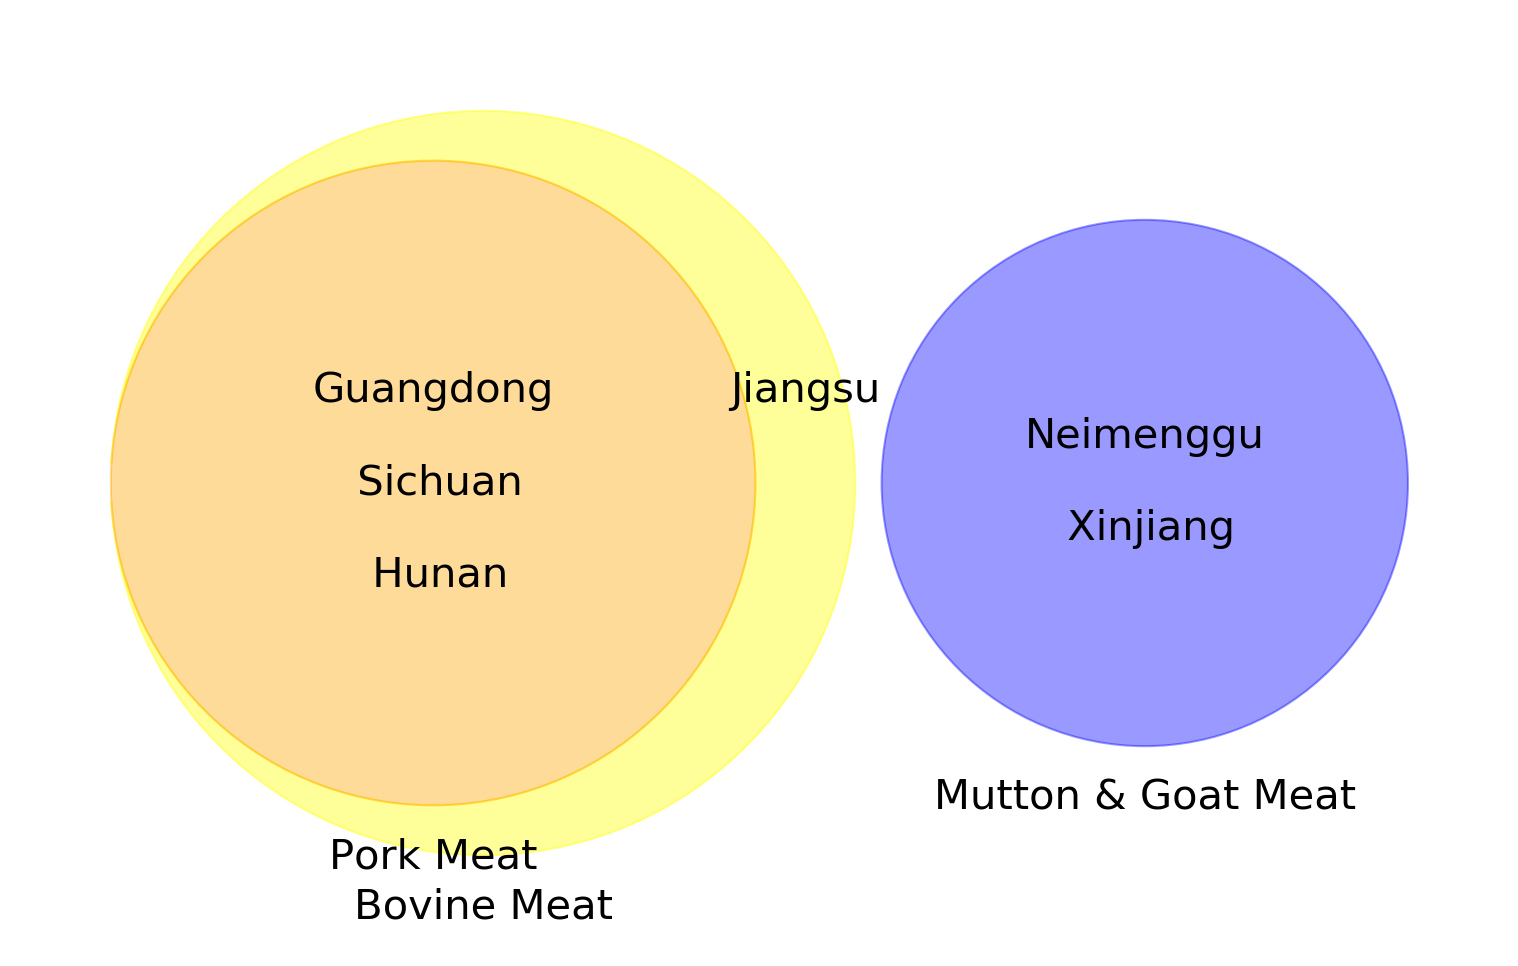

In [27]:
set1=top_pig
set2=top_cattle
set3=top_shp_gt
set1_name='Pork Meat'
set2_name='Bovine Meat'
set3_name='Mutton & Goat Meat'

drawVenn3(set1, set2, set3, set1_name, set2_name, set3_name)

Img saved as: ./results/img/CN_FoodConsumption/venn_Poultry Meat_Aquatic Meat.png


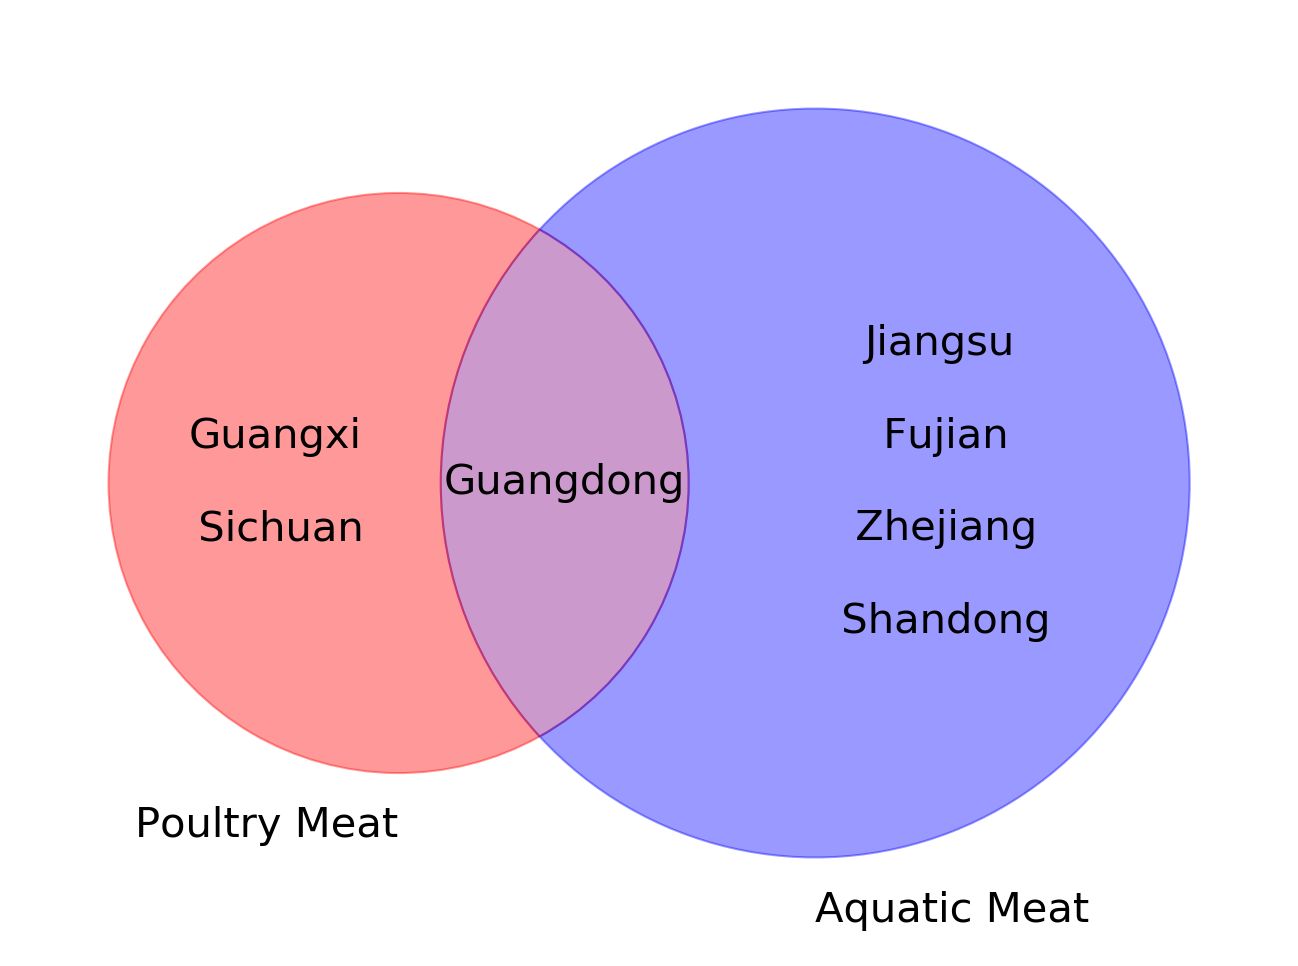

In [30]:
set1=top_poultry
set2=top_aquatic
set1_name='Poultry Meat'
set2_name='Aquatic Meat'

drawVenn2(set1,set2,set1_name,set2_name)

Img saved as: ./results/img/CN_FoodConsumption/venn_Egg_Milk.png


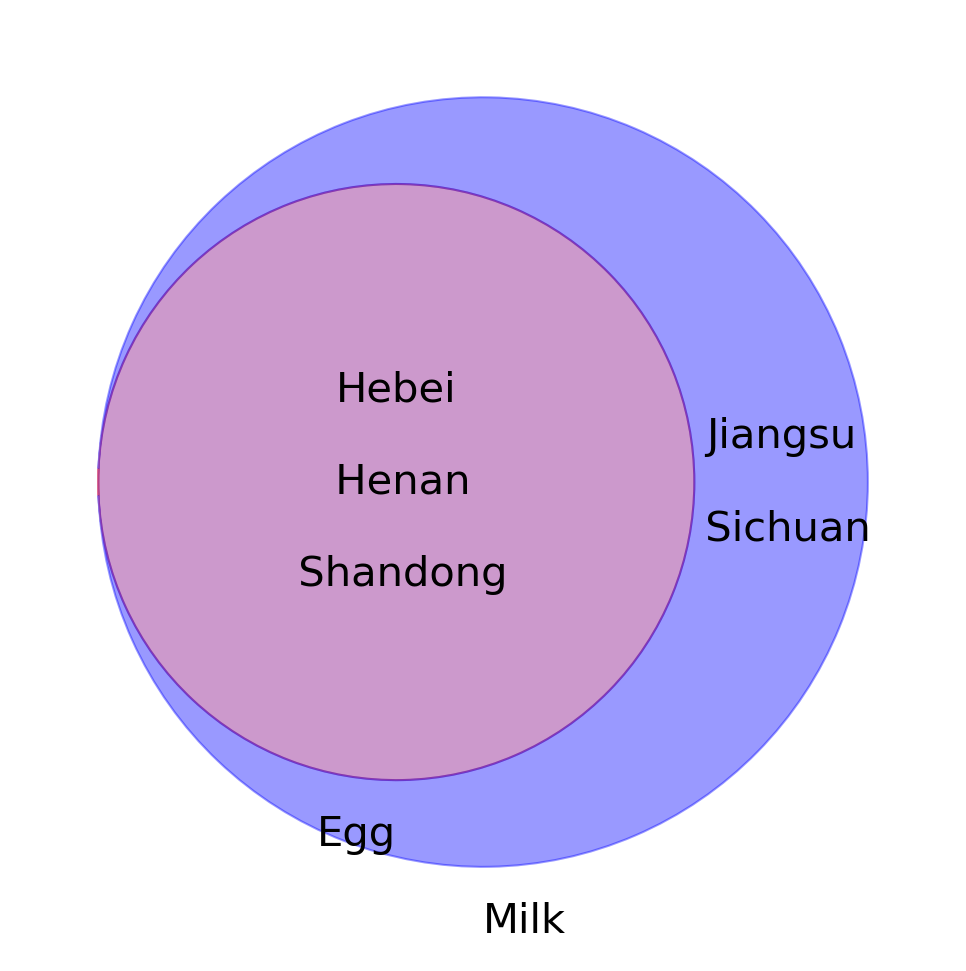

In [31]:
set1=top_egg
set2=top_milk
set1_name='Egg'
set2_name='Milk'

drawVenn2(set1,set2,set1_name,set2_name)

Img saved as: ./results/img/CN_FoodConsumption/venn_Red Meat_White Meat_Egg & Milk.png


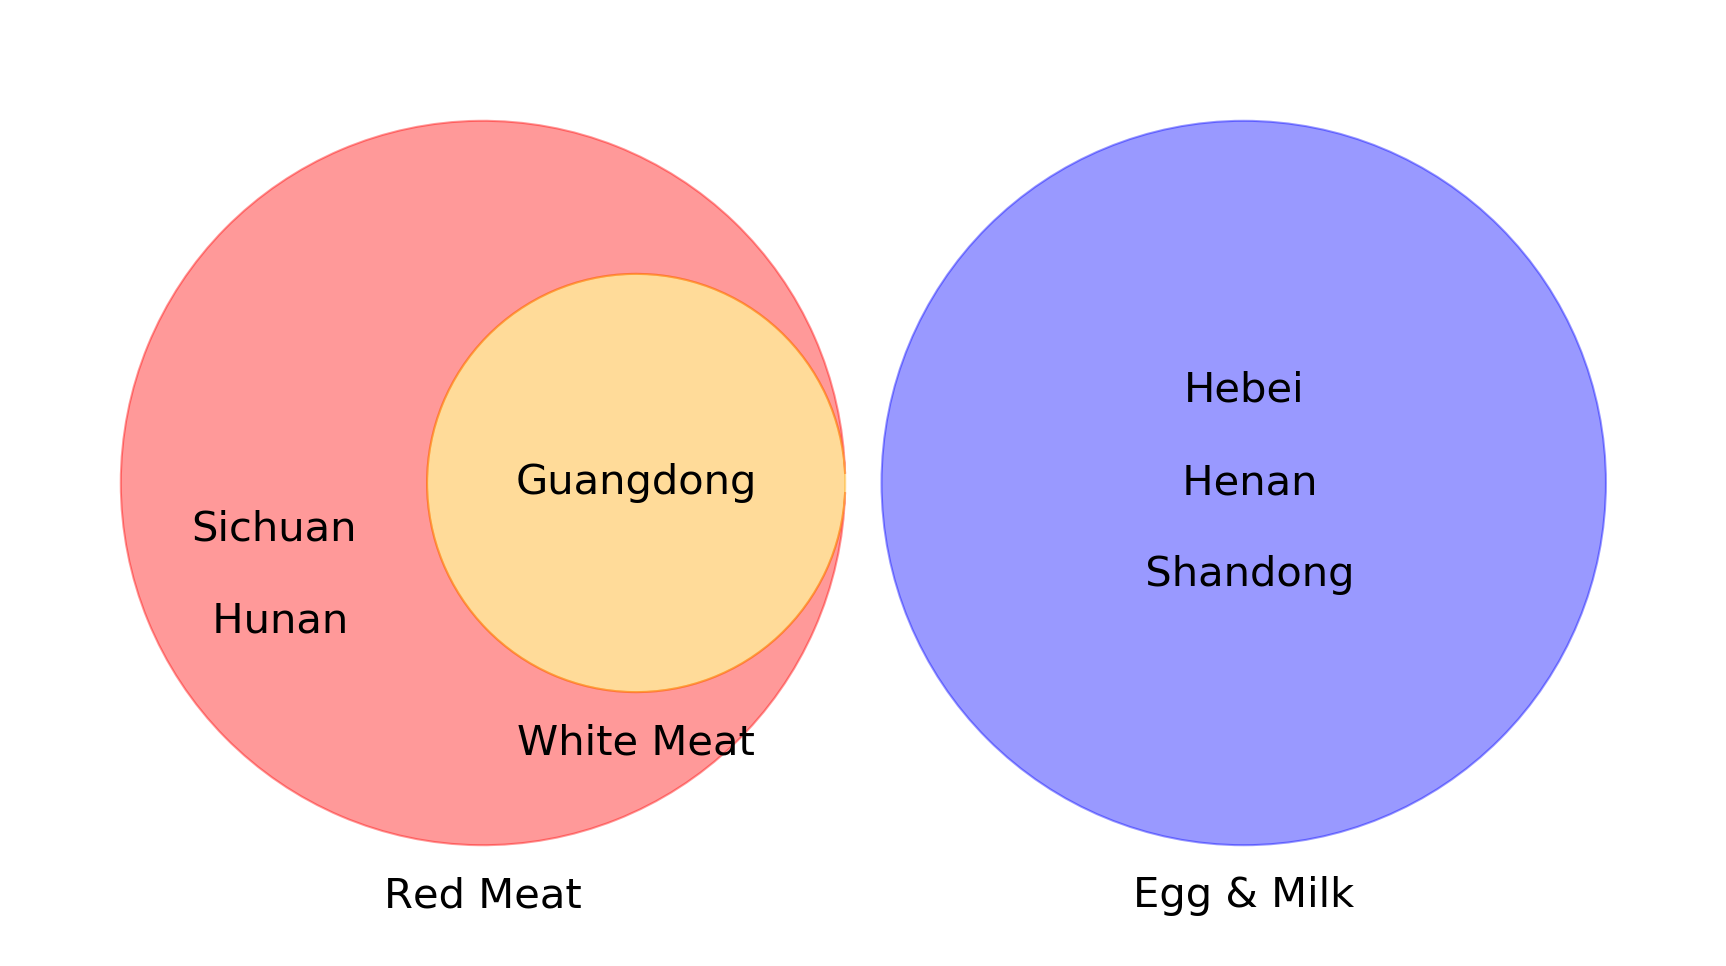

In [32]:
top_red={'Sichuan','Hunan','Guangdong'}
top_white={'Guangdong'}
top_egg_milk={'Shandong','Hebei','Henan'}

set1=top_red
set2=top_white
set3=top_egg_milk
set1_name='Red Meat'
set2_name='White Meat'
set3_name='Egg & Milk'
drawVenn3(set1,set2,set3,set1_name,set2_name,set3_name)

### 各地区城镇和农村的人均消费某动物产品占其主要食品消费量的百分比

Draw Bars and Atlas by Using __`percapita_norm`__

#### Over View with Bar plots

Img saved as: ./results/img/CN_FoodConsumption/Per Capita Daily Food Consumption in Different Areas of Mainland China in 2017.png


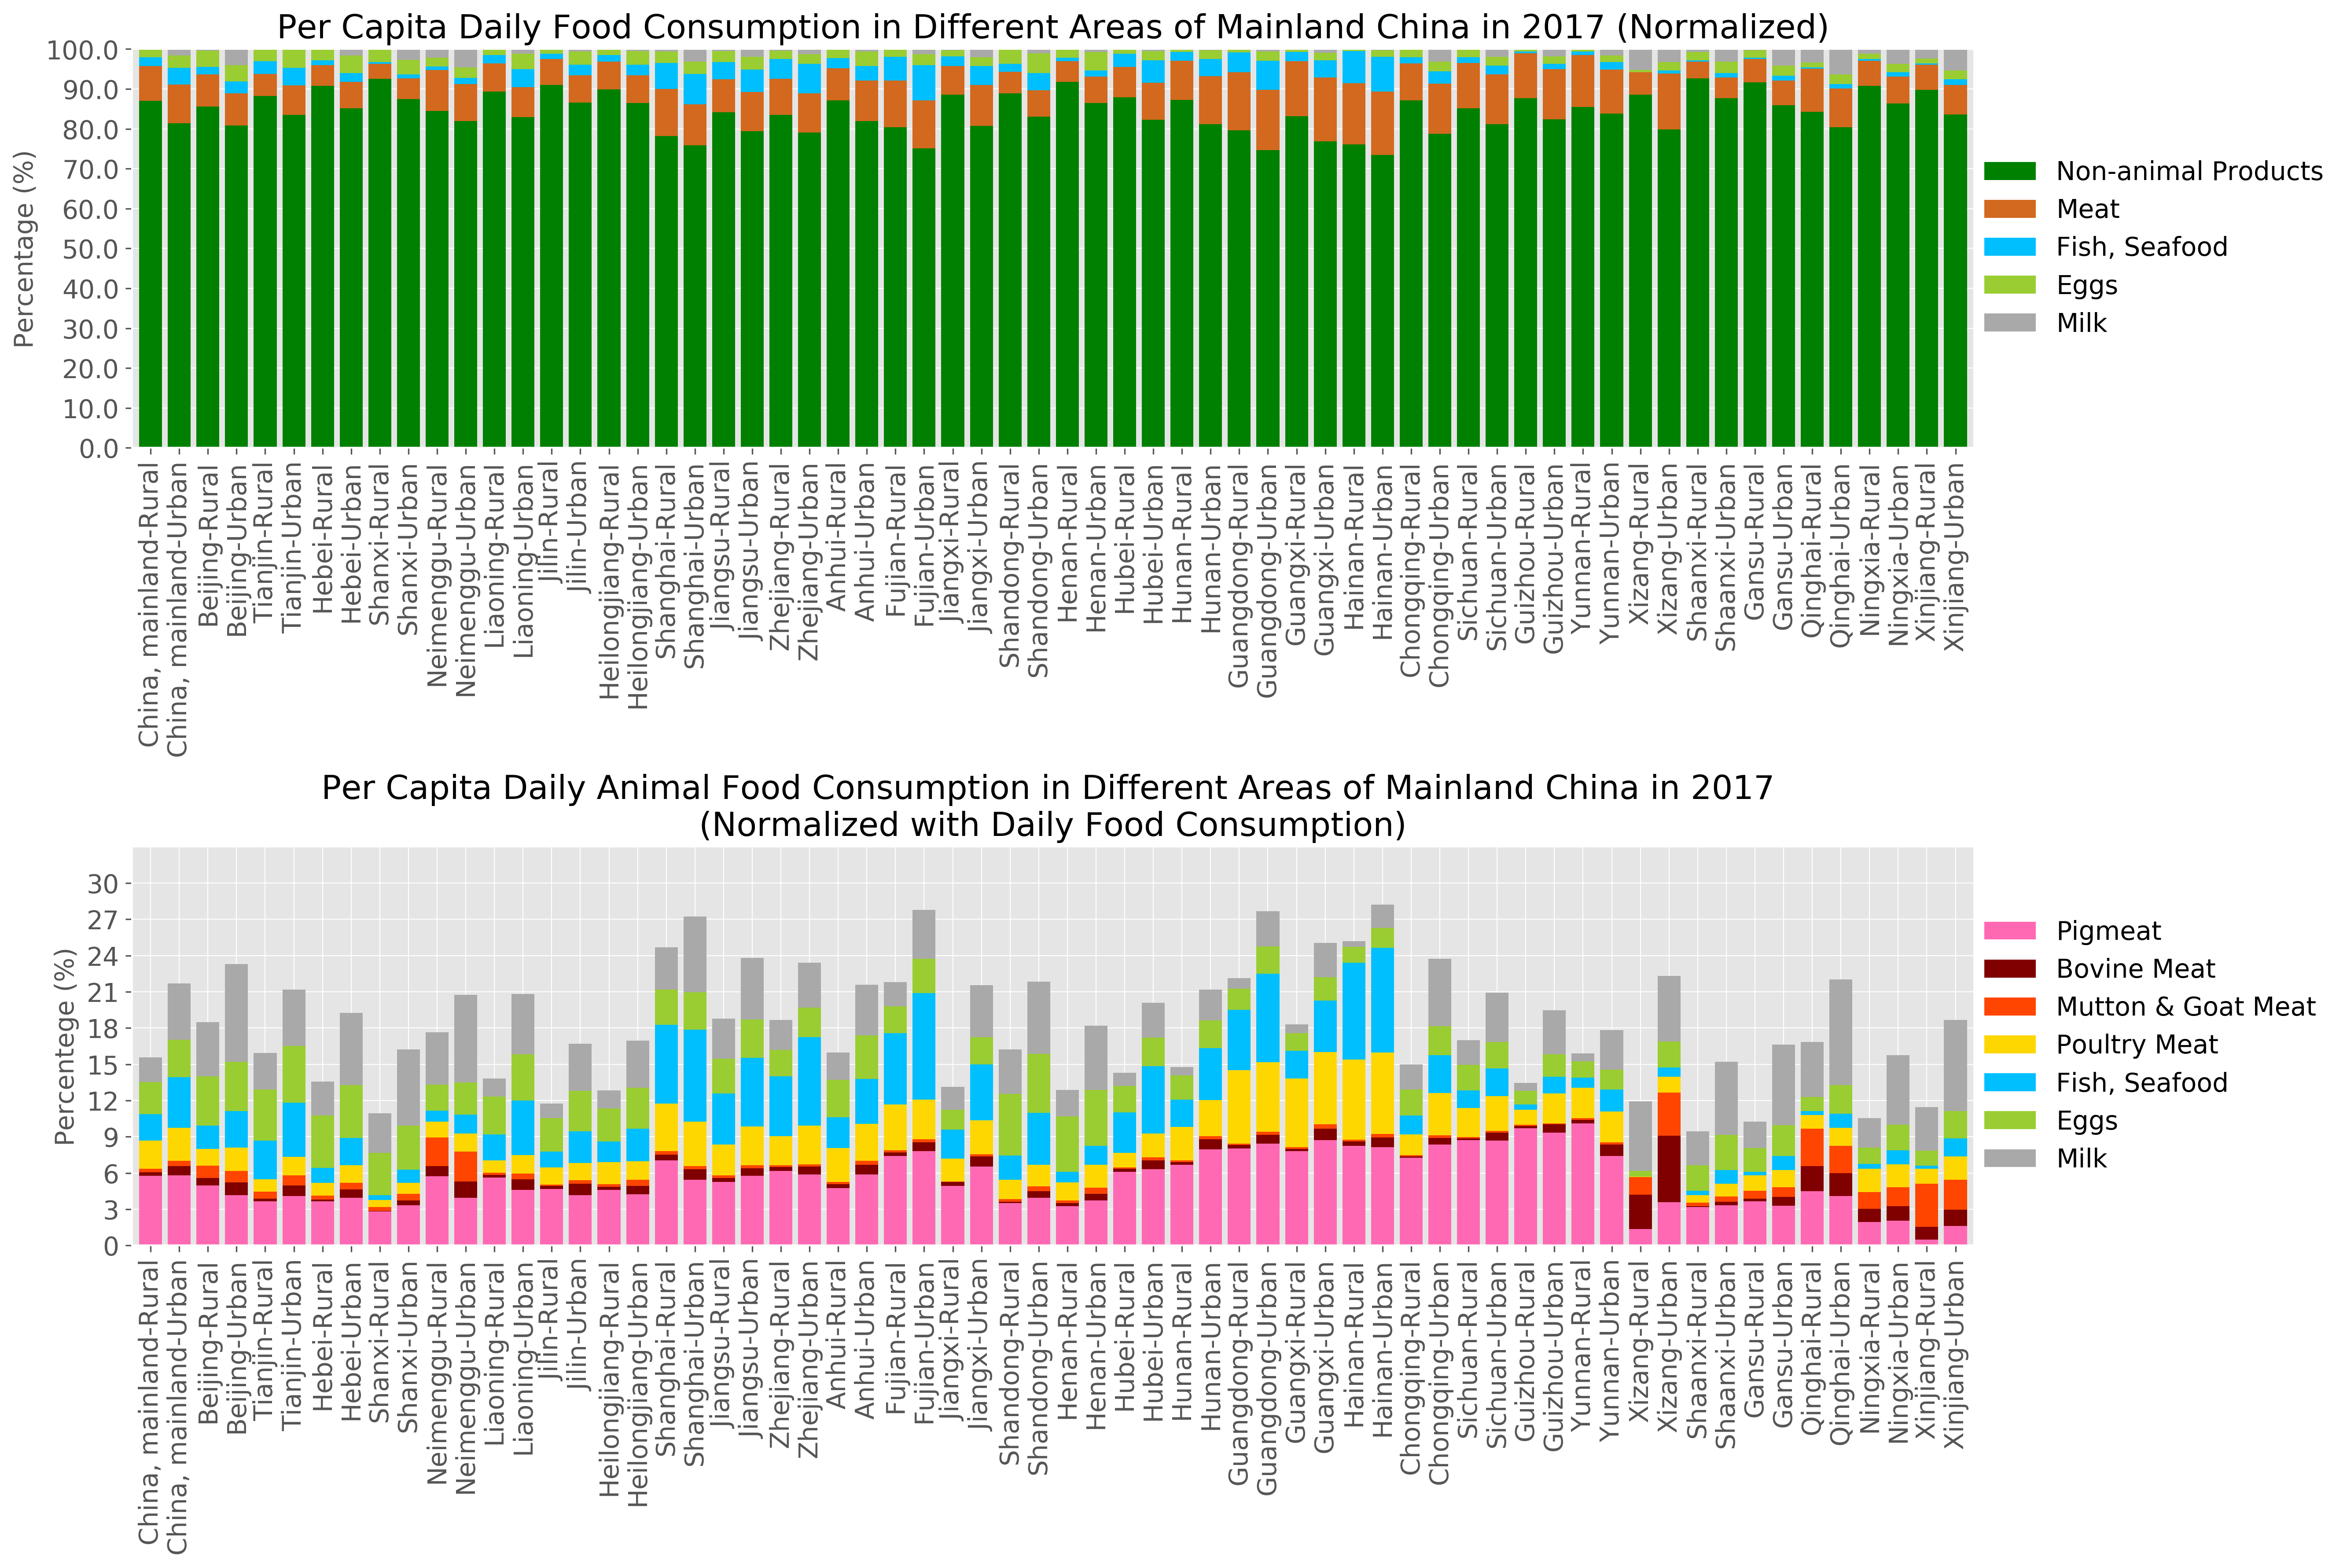

In [35]:
# 各地人均
df = percapita_norm

areas_multi = list(df[['Area','Urban or Rural']].values)

areas = []
for a in areas_multi:
    area = a[0]+'-'+a[1]
    areas.append(area)

fig = plt.figure(figsize = (18,12),dpi=300)
fig.tight_layout()                        
plt.subplots_adjust(wspace=0., hspace =1)
    
# ===
ax0 = fig.add_subplot(2,1,1)
plt.title("Per Capita Daily Food Consumption in Different Areas of Mainland China in 2017 (Normalized)", 
          fontsize=TIT_size)

cols = ['Non-animal Products','Meat','Fish, Seafood', 'Eggs', 'Milk']
colors = ('g','chocolate','deepskyblue','yellowgreen','darkgray')

percapita_norm[cols].plot.bar(stacked=True, width=BAR_wid, color=colors, ax=plt.gca())
    
ax=plt.gca()
ax.legend(loc='center left', frameon=False, fontsize=LEG_size,
           bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
setX_quali(ax, areas)
setY_per(ax)

# ===
ax1 = fig.add_subplot(2,1,2)
plt.title("Per Capita Daily Animal Food Consumption in Different Areas of Mainland China in 2017 \n(Normalized with Daily Food Consumption)", 
          fontsize=TIT_size)

cols = ['Pigmeat', 'Bovine Meat','Mutton & Goat Meat', 'Poultry Meat','Fish, Seafood', 'Eggs', 'Milk']

percapita_norm[cols].plot.bar(stacked=True, width=BAR_wid, color=CLs[3:], ax=plt.gca())
    
ax=plt.gca()
ax.legend(loc='center left', frameon=False, fontsize=LEG_size,
           bbox_to_anchor=(1.,0.5),borderaxespad = 0.)
setX_quali(ax, areas)
setY_quant(ax, 30, 'Percentege (%)')

 # === Save img
path = './results/img/CN_FoodConsumption/'+'Per Capita Daily Food Consumption in Different Areas of Mainland China in 2017'+'.png'
bbox = matplotlib.transforms.Bbox([[-0, -2], [20, 15]])
fig.savefig(path, format='png', transparent=False, dpi=300, bbox_inches =bbox)
print('Img saved as: ' + path)

#### Atlas for Urban

__注意：下个cell输出结果为地图，不能直接在文本中显示地图，请根据结果输出的地址自行查看__

In [17]:
# df_urb = df_percapita[df_percapita['Urban or Rural'] == 'Urban'] # 如果不使用归一化

df_urb = percapita_norm[percapita_norm['Urban or Rural'] == 'Urban'] 
plotAtlas(
    df_=df_urb,           # dataframe, the gross dataframe
    items_=items,         # string, selected item
    year_=2017,         # int, selected year
    geo_data_=r'cn_provinces.geojson',     # geojson file
    fill_color_='YlOrBr',   # string, select a fill_color strategy in folium
    tag_='Consumption in Urban'
)

,Area,Pigmeat,Area,Bovine Meat,Area,Mutton & Goat Meat,Area,Poultry Meat,Area,"Fish, Seafood",Area,Eggs,Area,Milk
0,Guizhou,9.325397,Xizang,5.483295,Xizang,3.570518,Hainan,6.751179,Fujian,8.812729,Shandong,4.889374,Qinghai,8.747795
1,Guangxi,8.725432,Qinghai,1.904762,Xinjiang,2.480774,Guangxi,5.985706,Hainan,8.667453,Tianjin,4.696970,Beijing,8.086253
2,Sichuan,8.670380,Xinjiang,1.364426,Neimenggu,2.449604,Guangdong,5.757757,Shanghai,7.623705,Henan,4.620750,Xinjiang,7.541553
3,Guangdong,8.412888,Neimenggu,1.352386,Qinghai,2.257496,Shanghai,3.653625,Zhejiang,7.327227,Hebei,4.342824,Neimenggu,7.246747
4,Chongqing,8.372322,Ningxia,1.205192,Ningxia,1.576020,Chongqing,3.472051,Guangdong,7.309069,Beijing,4.076819,Gansu,6.695819
5,Hainan,8.136792,Beijing,1.044474,Beijing,0.943396,Fujian,3.274174,Jiangsu,5.703849,Liaoning,3.798411,Shanxi,6.299462
6,Hunan,7.946454,Guangxi,0.952948,Tianjin,0.833333,Zhejiang,3.191785,Hubei,5.577329,Shanxi,3.640393,Shanghai,6.271577
7,Fujian,7.802938,Yunnan,0.942507,Gansu,0.819896,Jiangsu,3.175049,Jiangxi,4.652436,Anhui,3.588517,Shaanxi,6.047820
8,Yunnan,7.414389,Jilin,0.925407,Hebei,0.546448,Anhui,3.080144,Liaoning,4.543198,Heilongjiang,3.384861,Hebei,5.982169
9,Jiangxi,6.540777,Liaoning,0.893744,Shanxi,0.538145,Hunan,2.990601,Tianjin,4.494949,Jilin,3.337072,Shandong,5.981972


Atala saved as: ./results/map/CN_FoodConsumption/2017 Pigmeat Consumption in Urban.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Bovine Meat Consumption in Urban.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Mutton & Goat Meat Consumption in Urban.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Poultry Meat Consumption in Urban.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Fish, Seafood Consumption in Urban.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Eggs Consumption in Urban.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Milk Consumption in Urban.html


__注意：下个cell输出结果为地图，不能直接在文本中显示地图，请根据结果输出的地址自行查看__

In [18]:
df_rur = df_percapita[df_percapita['Urban or Rural'] == 'Rural']

plotAtlas(
    df_=df_rur,           # dataframe, the gross dataframe
    items_=items,         # string, selected item
    year_=2017,         # int, selected year
    geo_data_=r'cn_provinces.geojson',     # geojson file
    fill_color_='YlOrBr',   # string, select a fill_color strategy in folium
    tag_='Consumption in Rural'
)

,Area,Pigmeat,Area,Bovine Meat,Area,Mutton & Goat Meat,Area,Poultry Meat,Area,"Fish, Seafood",Area,Eggs,Area,Milk
0,Sichuan,36.5,Xizang,11.3,Xinjiang,13.1,Guangdong,23.5,Shanghai,22.3,Tianjin,16.7,Xizang,22.9
1,Chongqing,33.6,Qinghai,5.2,Neimenggu,8.0,Guangxi,19.2,Fujian,21.3,Shandong,16.3,Neimenggu,14.6
2,Guangdong,31.0,Xinjiang,3.8,Qinghai,7.8,Hainan,17.5,Hainan,21.2,Henan,13.0,Xinjiang,13.2
3,Yunnan,29.0,Ningxia,3.3,Xizang,5.8,Fujian,13.6,Guangdong,19.2,Hebei,13.0,Beijing,12.9
4,Guizhou,27.1,Neimenggu,2.8,Ningxia,4.2,Shanghai,13.4,Zhejiang,18.6,Beijing,11.8,Shanghai,12.0
5,Fujian,26.6,Shanghai,1.7,Beijing,3.0,Hunan,10.9,Jiangsu,14.2,Anhui,11.2,Tianjin,12.0
6,Guangxi,26.3,Beijing,1.7,Tianjin,2.3,Sichuan,10.1,Tianjin,12.6,Liaoning,10.3,Shandong,11.7
7,Hunan,26.3,Zhejiang,1.3,Gansu,2.0,Anhui,10.1,Hubei,11.1,Shanxi,10.2,Qinghai,11.4
8,Shanghai,24.1,Anhui,1.2,Shanghai,1.0,Zhejiang,9.0,Anhui,9.3,Shanghai,10.0,Jiangsu,11.1
9,Zhejiang,23.1,Jiangsu,1.1,"China, mainland",1.0,Jiangsu,8.5,Hunan,8.9,Chongqing,9.9,Shanxi,9.6


Atala saved as: ./results/map/CN_FoodConsumption/2017 Pigmeat Consumption in Rural.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Bovine Meat Consumption in Rural.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Mutton & Goat Meat Consumption in Rural.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Poultry Meat Consumption in Rural.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Fish, Seafood Consumption in Rural.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Eggs Consumption in Rural.html
Atala saved as: ./results/map/CN_FoodConsumption/2017 Milk Consumption in Rural.html
